<a href="https://colab.research.google.com/github/TaniaZharova2205/HSE/blob/main/DZ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [ ]:
df = pd.read_csv('https://storage.yandexcloud.net/datasouls-ods/materials/04adaecc/interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
2583174,45611,16509,160,280,0.0
400534,958208,4702,91,263,4.0
1716897,521098,15266,59,3030,57.0
2038949,507251,12770,91,214,4.0
1542857,180749,9996,89,39678,100.0


<Axes: >

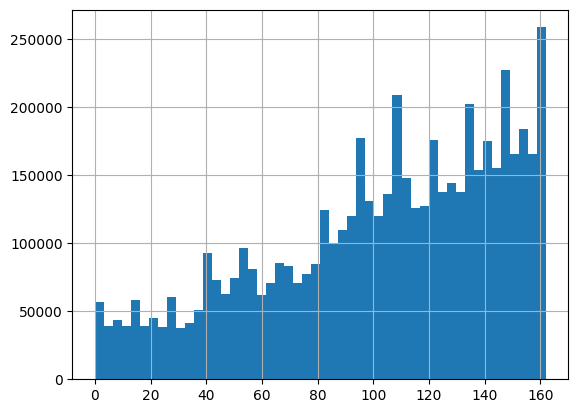

In [ ]:
df.last_watch_dt.hist(bins=50)

In [ ]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [ ]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

In [ ]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [ ]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
27,841859,3935,94,8862,100.0
56,580093,15411,151,10479,100.0
162,231912,3363,122,444,7.0
183,339681,13865,92,6460,100.0
186,450102,3130,85,682,9.0


In [ ]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

<ipython-input-9-2ac47bd011f3>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
<ipython-input-9-2ac47bd011f3>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,96,"[(15297, 148)]"
1,157,"[(10440, 142), (15297, 143), (4713, 151), (124..."
2,244,"[(9427, 107), (11228, 107), (15096, 108), (738..."
3,272,"[(12869, 40), (11310, 112)]"
4,414,"[(10440, 152), (2940, 152)]"


In [ ]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,96,"[(15297, 148)]","[(12360, 158)]"
1,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]"
2,244,"[(9427, 107), (11228, 107), (15096, 108), (738...","[(9728, 157), (5803, 157)]"
3,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214..."
4,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,..."


In [ ]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn) for _ in range(len(df))]


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,96,"[(15297, 148)]","[(12360, 158)]","[5699, 8571, 11287]"
1,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[10492, 13396, 6536]"
2,244,"[(9427, 107), (11228, 107), (15096, 108), (738...","[(9728, 157), (5803, 157)]","[12895, 5956, 7614]"
3,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[14974, 4217, 8373]"
4,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,...","[11940, 2351, 599]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [ ]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
) -> float:
    gt_set = set(gt_items)
    if topn is None:
        topn = len(predictions)
    preds_at_k = predictions[:topn]
    relevance = np.in1d(preds_at_k, list(gt_set)).astype(np.float32)
    if relevance.sum() == 0:
        return 0.0
    precision_at_k = np.cumsum(relevance) / np.arange(1, len(relevance)+1)
    result = np.sum(relevance * precision_at_k) / min(topn, len(gt_items))
    return result

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
) -> float:
    gt_set = set(gt_items)
    if topn is None:
        topn = len(predictions)
    preds = np.array(predictions[:topn])
    relevance = np.in1d(preds, list(gt_set))
    indices = np.where(relevance)[0]
    if indices.size == 0:
        return 0.0
    first_index = indices[0]
    return 1.0 / (first_index + 1)


def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
) -> float:
    gt_set = set(gt_items)
    if topn is None:
        topn = len(predictions)

    preds_at_k = predictions[:topn]
    r = np.in1d(preds_at_k, list(gt_set))
    return 1.0 if np.any(r) else 0.0

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит.

In [ ]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать.

In [ ]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [ ]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.00018888888888888886, 'mrr': 0.0005666666666666666, 'hr': 0.001}

In [ ]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):
        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,96,"[(15297, 148)]","[(12360, 158)]","[5699, 8571, 11287]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
1,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[10492, 13396, 6536]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
2,244,"[(9427, 107), (11228, 107), (15096, 108), (738...","[(9728, 157), (5803, 157)]","[12895, 5956, 7614]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
3,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[14974, 4217, 8373]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
4,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,...","[11940, 2351, 599]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [ ]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06806048546548249, 'mrr': 0.12125099206349207, 'hr': 0.2755}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [ ]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        # Найдём максимальное время взаимодействия во всех списках
        max_time = 0
        for _, row in df.iterrows():
            if row[col]:
                current_max = max(ts for _, ts in row[col])
                if current_max > max_time:
                    max_time = current_max

        # Определяем пороговое время: учитываем только те взаимодействия, которые произошли после (max_time - min_window)
        threshold = max_time - self.min_window
        counts = {}
        for _, row in df.iterrows():
            for item, ts in row[col]:
                if ts >= threshold:
                    counts[item] = counts.get(item, 0) + 1

        # Сортируем по убыванию количества
        counts_sorted = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        self.recommenations = [x[0] for x in counts_sorted]
        self.trained = True

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

In [ ]:
window_sizes = [2, 5, 10, 20, 30, 40, 50]
ap_scores, rr_scores, hr_scores = [], [], []

for window in window_sizes:
    toppop_weighted = TopPopularWeighted(min_window=window)
    toppop_weighted.fit(joined, col='train_interactions')
    joined['toppopular_weighted'] = toppop_weighted.predict(joined)
    met = evaluate_recommender(joined, model_preds='toppopular_weighted')
    ap_scores.append(met['map'])
    rr_scores.append(met['mrr'])
    hr_scores.append(met['hr'])
    joined.drop(columns=['toppopular_weighted'], axis=1)

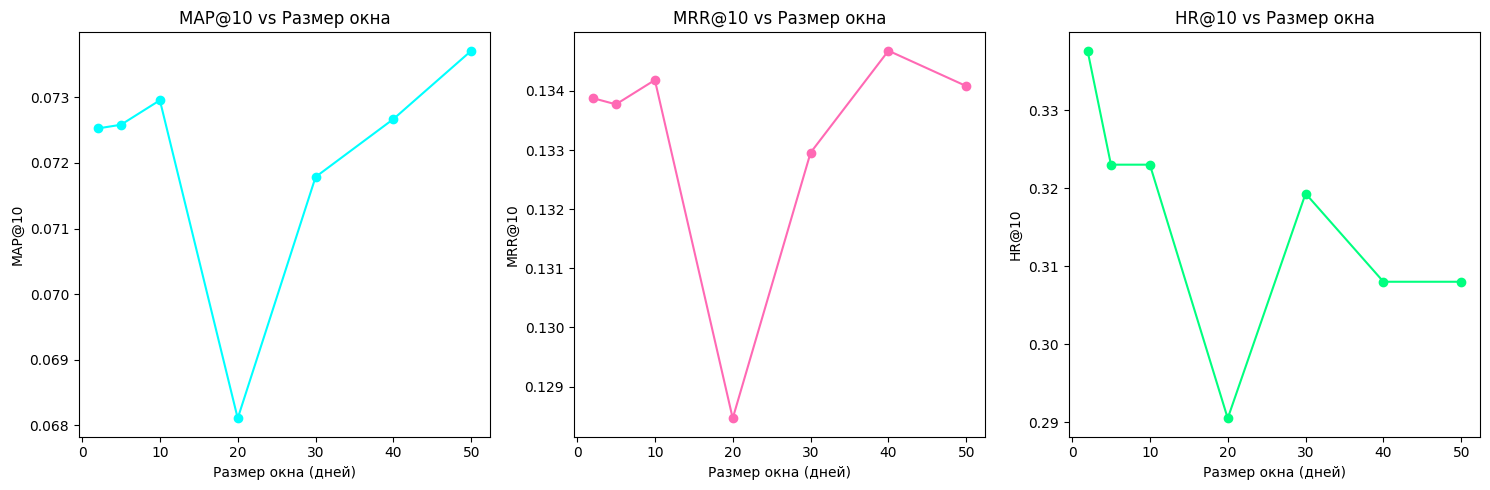

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(window_sizes, ap_scores, marker='o', color="#00FFFF")
plt.xlabel('Размер окна (дней)')
plt.ylabel('MAP@10')
plt.title('MAP@10 vs Размер окна')

plt.subplot(1,3,2)
plt.plot(window_sizes, rr_scores, marker='o', color="#FF69B4")
plt.xlabel('Размер окна (дней)')
plt.ylabel('MRR@10')
plt.title('MRR@10 vs Размер окна')

plt.subplot(1,3,3)
plt.plot(window_sizes, hr_scores, marker='o', color="#00FF7F")
plt.xlabel('Размер окна (дней)')
plt.ylabel('HR@10')
plt.title('HR@10 vs Размер окна')

plt.tight_layout()
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**

При небольшом размере окна учитываются только самые свежие взаимодействия, что позволяет лучше отражать актуальные предпочтения пользователей, особенно если их интересы быстро меняются. В таких случаях метрики (AP, RR, HR) могут быть выше. Однако слишком малое окно может содержать недостаточно данных, что вносит «шум» и снижает качество рекомендаций.

С другой стороны, при увеличении окна в выборку попадают устаревшие взаимодействия, которые уже не соответствуют текущим интересам пользователя, что также может ухудшить качество рекомендаций.

Таким образом, оптимальный размер окна — это баланс между свежестью данных и их достаточным объемом. По метрикам MRR и MAP наилучший результат достигается при окне около 40-50 дней, тогда как для HR оптимальным является диапазон до 10 дней.

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике.

In [ ]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [ ]:
k_values = np.arange(1, 101)  # Значения K от 1 до 100
map_scores, mrr_scores, hr_scores = [], [], []

for k in k_values:
    ap_list = []
    rr_list = []
    hr_list = []

    for idx, row in joined.iterrows():
        gt_items = [x[0] for x in row['test_interactions']]
        predictions = row['toppopular_recs'][:k]

        ap = ap_metric(gt_items, predictions, topn=k)
        rr = rr_metric(gt_items, predictions, topn=k)
        hr = hr_metric(gt_items, predictions, topn=k)

        ap_list.append(ap)
        rr_list.append(rr)
        hr_list.append(hr)

    # Усредняем метрики по всем пользователям
    map_scores.append(np.mean(ap_list))
    mrr_scores.append(np.mean(rr_list))
    hr_scores.append(np.mean(hr_list))

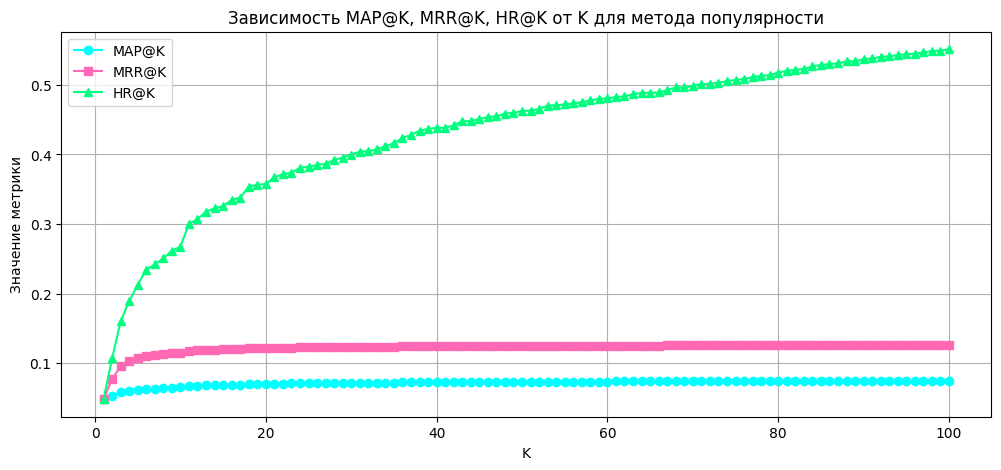

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(k_values, map_scores, label="MAP@K", marker='o', linestyle='-', color="#00FFFF")
plt.plot(k_values, mrr_scores, label="MRR@K", marker='s', linestyle='-', color="#FF69B4")
plt.plot(k_values, hr_scores, label="HR@K", marker='^', linestyle='-', color="#00FF7F")

plt.xlabel("K")
plt.ylabel("Значение метрики")
plt.title("Зависимость MAP@K, MRR@K, HR@K от K для метода популярности")
plt.legend()
plt.grid(True)
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \

1. HR@K - eсли элемент уже найден в меньшем K, то он сохранится и в большем K.
2. MAP@K - добавление новых элементов в рекомендации не ухудшает точность, но может незначительно изменять её.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \

1. HR@K - Рост означает, что с увеличением длины списка рекомендаций шанс угадать хотя бы один нужный элемент становится выше.
2. MAP@K - показывает общую точность списка: насколько высоко расположены релевантные рекомендации. Метрика незначительно больше имеет значения, нежели HR@K.
3. MRR@K - учитывает позицию первого релевантного элемента.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\

1. HR@K растёт ожидаемо, так как добавление новых элементов увеличивает вероятность попадания правильного ответа.
2. MAP@K растёт медленно: чем больше K, тем больше нерелевантных элементов, что ограничивает рост точности.
3. MRR@K почти плоский - влияет только первая правильная рекомендация: если она попала в топ, дальше ничего не меняется. Если релевантные элементы появляются только при больших K, MRR@K может падать.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [ ]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

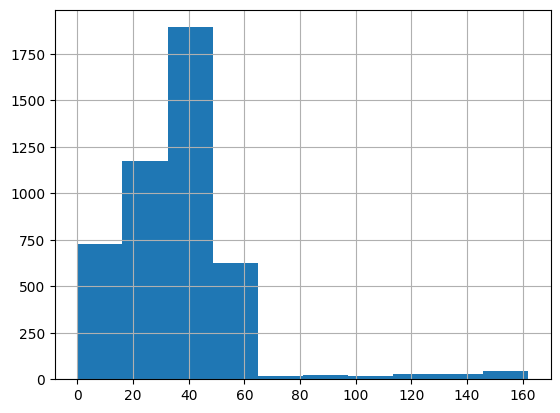

In [ ]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

In [ ]:
def get_trend_pattern(df):
    """Определяет тренд популярности фильма"""
    views_by_day = df["last_watch_dt"].value_counts().sort_index()
    if len(views_by_day) < 10:
        return None
    first_peak = views_by_day.iloc[:10].sum()
    last_peak = views_by_day.iloc[-10:].sum()
    total_views = views_by_day.sum()

    # Сильный старт → спад
    if first_peak / total_views > 0.6:
        return "hype"
    # Было популярно → резко упало
    if first_peak > last_peak * 3:
        return "forgotten_hit"
    # Пики через равные промежутки
    if views_by_day.diff().abs().mean() > views_by_day.mean() * 0.5:
        return "seasonal"
    # Резкий рост спустя долгое время
    if last_peak > first_peak * 3:
        return "viral"
    # Примерно одинаковые просмотры всегда
    return "stable"
patterns = {"hype": [], "forgotten_hit": [], "seasonal": [], "viral": [], "stable": []}

for sample_id in items["item_id"].unique():
    interactions = df[df["item_id"] == sample_id]
    pattern = get_trend_pattern(interactions)
    if pattern and len(patterns[pattern]) < 1:
        patterns[pattern].append(sample_id)

# Берем по 1 фильму из каждого паттерна
sample_ids = [patterns[key][0] for key in patterns if patterns[key]]

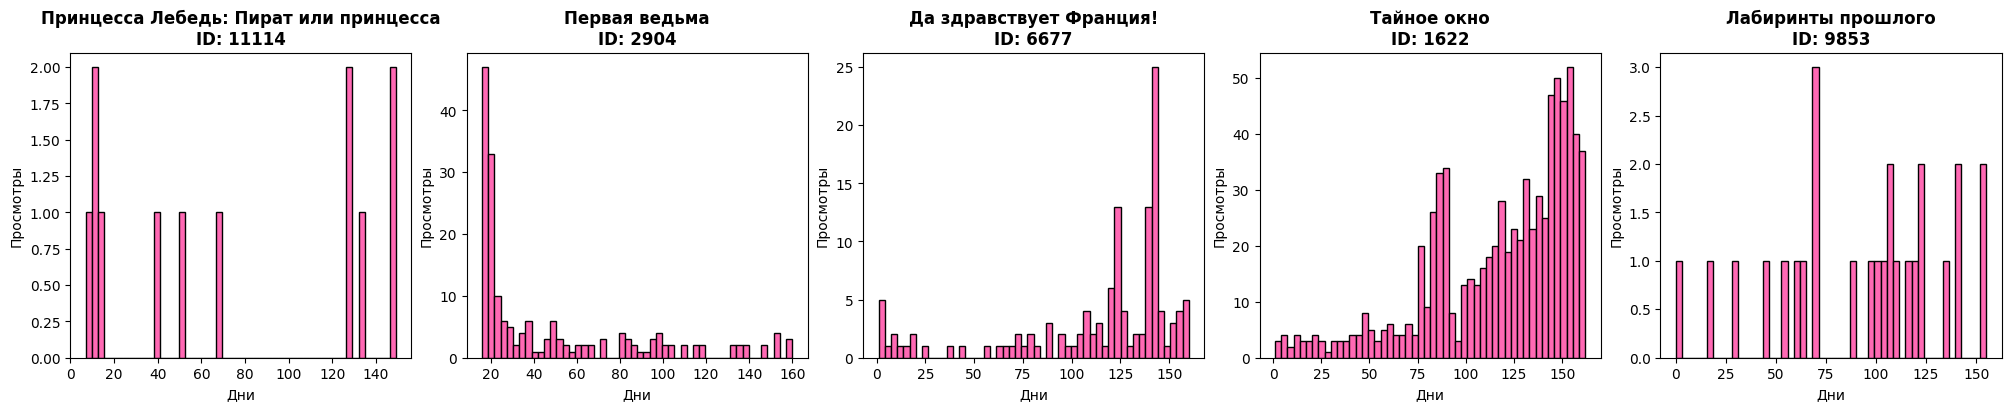

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), constrained_layout=True)
for ax, sample_id in zip(axes, sample_ids):
    interactions = df[df["item_id"] == sample_id]
    title = items.loc[items["item_id"] == sample_id, "title"].values[0]
    ax.hist(interactions["last_watch_dt"], bins=50, color="#FF69B4", edgecolor="black")
    ax.set_title(f"{title}\nID: {sample_id}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Дни", fontsize=10)
    ax.set_ylabel("Просмотры", fontsize=10)
plt.show()

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [ ]:
def filter_column(df, col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    frequent_values = df[col].value_counts()
    valid_values = frequent_values[frequent_values >= min_freq].index
    return df[df[col].isin(valid_values)]

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    df_filtered = df.copy()
    while True:
        initial_size = len(df_filtered)
        for column in cols:
            df_filtered = filter_column(df_filtered, column, min_freq)
        if len(df_filtered) == initial_size:
            break
    return df_filtered

filtered_train = filter_dataframe(df, ['user_id', 'item_id'], min_freq=5)
print('Было:', df.shape[0])
print(f"Осталось {filtered_train.shape[0]} интеракций после фильтрации.")

Было: 5476250
Осталось 4278492 интеракций после фильтрации.


In [ ]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df, user2id, item2id

filtered_train, user2id, item2id = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
4662088,138914,1711,122,5230,97.0
4360676,294572,12,114,7536,100.0
1531211,219323,4970,138,4707,13.0
2498457,63211,2617,157,1817,38.0
2902010,63593,1245,127,1434,17.0


In [ ]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<302205x10031 sparse matrix of type '<class 'numpy.float64'>'
	with 4278492 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра.

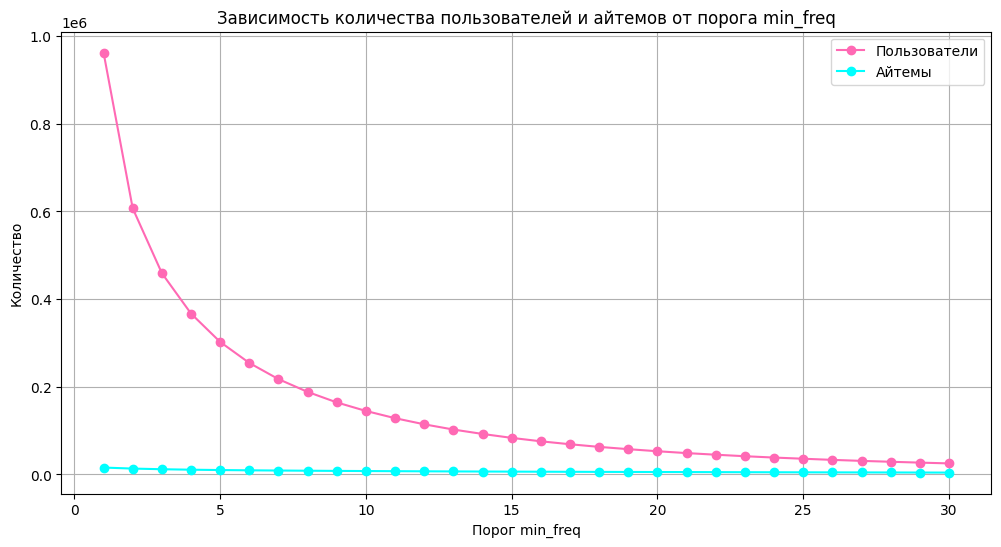

In [ ]:
# Определяем диапазон порога min_freq от 1 до 30
min_freq_range = range(1, 31)
users_count, items_count, interactions_count = [], [], []

for min_freq in min_freq_range:
    filtered_df = filter_dataframe(df, ['user_id', 'item_id'], min_freq=min_freq)
    # Запоминаем количество уникальных пользователей, айтемов и интеракций
    users_count.append(filtered_df['user_id'].nunique())
    items_count.append(filtered_df['item_id'].nunique())
    interactions_count.append(len(filtered_df))

plt.figure(figsize=(12, 6))
plt.plot(min_freq_range, users_count, marker='o', label="Пользователи", color="#FF69B4")
plt.plot(min_freq_range, items_count, marker='o', label="Айтемы", color = '#00FFFF')
plt.xlabel("Порог min_freq")
plt.ylabel("Количество")
plt.title("Зависимость количества пользователей и айтемов от порога min_freq")
plt.legend()
plt.grid(True)
plt.show()

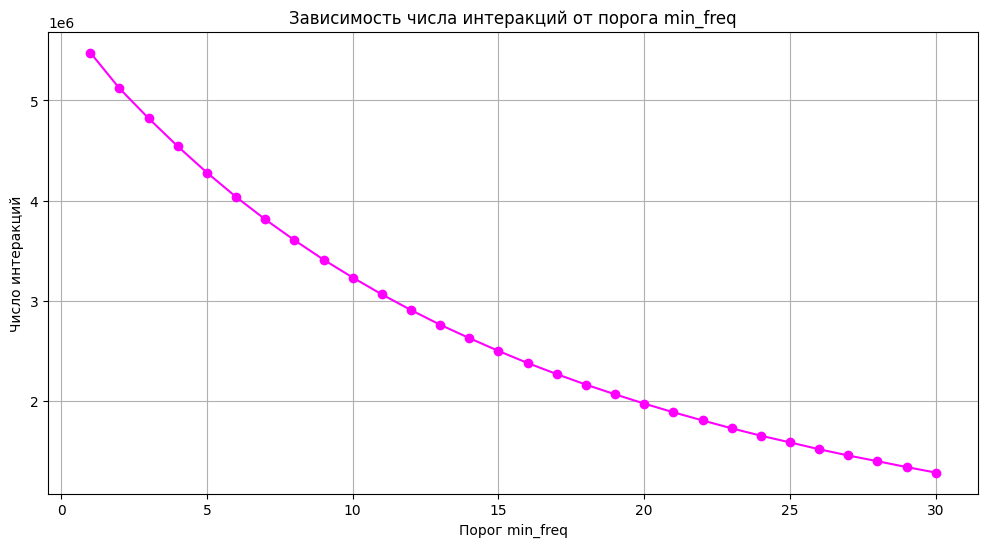

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(min_freq_range, interactions_count, marker='o', color='#FF00FF')
plt.xlabel("Порог min_freq")
plt.ylabel("Число интеракций")
plt.title("Зависимость числа интеракций от порога min_freq")
plt.grid(True)
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k.

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [ ]:
%%time

# Обучаем конечную модель. Была взята реализация из RecBole
def fit_ease(X, reg_weight=1000):
    G = (X.T @ X).toarray()  # Граммова матрица (Item × Item)
    diag_indices = np.diag_indices(G.shape[0])
    G[diag_indices] += reg_weight  # Регуляризация
    P = np.linalg.inv(G)  # Инверсия матрицы
    B = P / -np.diag(P)  # Нормализация
    B[diag_indices] = 0
    return B

w = fit_ease(matrix)

CPU times: user 2min 42s, sys: 3.58 s, total: 2min 46s
Wall time: 1min 39s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [ ]:
%%time
def get_preds(x, item2id, id2item):
    n_items = len(item2id)
    # Формируем бинарный вектор для пользователя (1 – если пользователь уже смотрел айтем)
    user_vec = np.zeros(n_items)
    for item, ts in x:
        if item in item2id:
            user_vec[item2id[item]] = 1

    scores = user_vec.dot(w)
    seen_indices = [item2id[item] for item, ts in x if item in item2id]
    scores[seen_indices] = -np.inf
    ranking = np.argsort(-scores)
    decoded = [id2item[idx] for idx in ranking]
    return decoded
id2item = {v: k for k, v in item2id.items()}

joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

CPU times: user 21min 4s, sys: 1min 34s, total: 22min 39s
Wall time: 13min 2s


,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,ease_preds
0,96,"[(15297, 148)]","[(12360, 158)]","[5699, 8571, 11287]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 4151, 12192, 13865, 16228, 3734, 142, ..."
1,157,"[(10440, 142), (15297, 143), (4713, 151), (124...","[(16228, 156), (2616, 160)]","[10492, 13396, 6536]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[4151, 16228, 13865, 12192, 9728, 2657, 9996, ..."
2,244,"[(9427, 107), (11228, 107), (15096, 108), (738...","[(9728, 157), (5803, 157)]","[12895, 5956, 7614]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15531, 101, 14304, 12463, 3170, 14470, 14684,..."
3,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[14974, 4217, 8373]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[12275, 13018, 9091, 5250, 12173, 14741, 4696,..."
4,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,...","[11940, 2351, 599]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 13865, 9728, 2657, 9996, 142, 4880, 41..."


In [ ]:
print("Метрики для TopPopular: ", evaluate_recommender(joined, model_preds='toppopular_recs'))
print("Метрики для EASE: ", evaluate_recommender(joined, model_preds='ease_preds'))

Метрики для TopPopular:  {'map': 0.07781517515179956, 'mrr': 0.13287647580236397, 'hr': 0.5634}
Метрики для EASE:  {'map': 0.10988852208074325, 'mrr': 0.18342863171263787, 'hr': 0.9995}


Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**

Алгоритм EASE показывает лучше результаты по MAP, MRR и HR в отличие от TopPopular, что указывает на то

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

In [ ]:
# Определяем сетку значений reg_weight по логарифмической шкале
reg_grid = np.logspace(1, 5, num=20)
ease_map = []
ease_mrr = []
ease_hr  = []

for reg in reg_grid:
    w = fit_ease(matrix, reg_weight=reg)
    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
    metrics = evaluate_recommender(joined, model_preds='ease_preds')
    ease_map.append(metrics['map'])
    ease_mrr.append(metrics['mrr'])
    ease_hr.append(metrics['hr'])
    print(f"reg_weight: {reg:.3f}  ->  MAP: {metrics['map']:.5f},  MRR: {metrics['mrr']:.5f},  HR: {metrics['hr']:.5f}")

reg_weight: 10.000  ->  MAP: 0.12041,  MRR: 0.19200,  HR: 0.99910
reg_weight: 16.238  ->  MAP: 0.11819,  MRR: 0.19007,  HR: 0.99910
reg_weight: 26.367  ->  MAP: 0.11585,  MRR: 0.18795,  HR: 0.99910
reg_weight: 42.813  ->  MAP: 0.11387,  MRR: 0.18605,  HR: 0.99910
reg_weight: 69.519  ->  MAP: 0.11251,  MRR: 0.18512,  HR: 0.99910
reg_weight: 112.884  ->  MAP: 0.11091,  MRR: 0.18324,  HR: 0.99910
reg_weight: 183.298  ->  MAP: 0.10960,  MRR: 0.18181,  HR: 0.99910
reg_weight: 297.635  ->  MAP: 0.10840,  MRR: 0.18062,  HR: 0.99910
reg_weight: 483.293  ->  MAP: 0.10722,  MRR: 0.17895,  HR: 0.99910
reg_weight: 784.760  ->  MAP: 0.10658,  MRR: 0.17761,  HR: 0.99910
reg_weight: 1274.275  ->  MAP: 0.10579,  MRR: 0.17642,  HR: 0.99910
reg_weight: 2069.138  ->  MAP: 0.10516,  MRR: 0.17526,  HR: 0.99910
reg_weight: 3359.818  ->  MAP: 0.10418,  MRR: 0.17373,  HR: 0.99910
reg_weight: 5455.595  ->  MAP: 0.10399,  MRR: 0.17296,  HR: 0.99910
reg_weight: 8858.668  ->  MAP: 0.10344,  MRR: 0.17199,  HR: 0.9

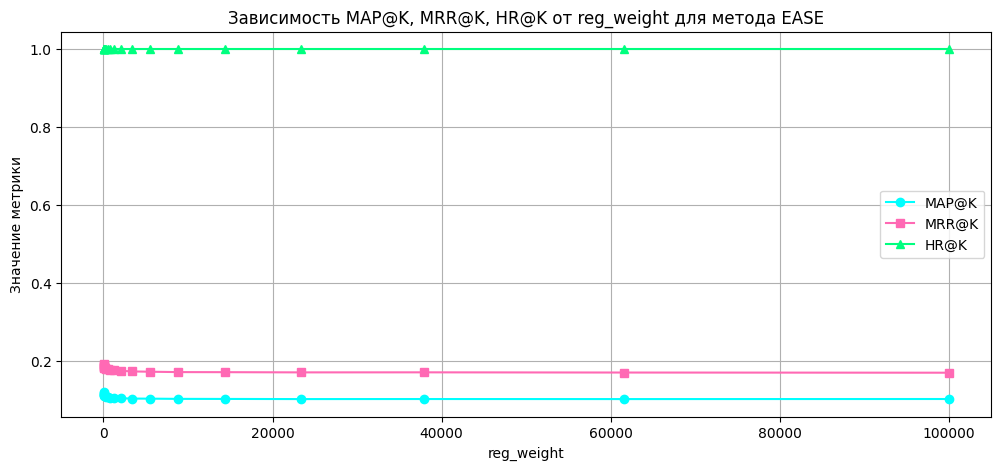

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(reg_grid, ease_map, label="MAP@K", marker='o', linestyle='-', color="#00FFFF")
plt.plot(reg_grid, ease_mrr, label="MRR@K", marker='s', linestyle='-', color="#FF69B4")
plt.plot(reg_grid, ease_hr, label="HR@K", marker='^', linestyle='-', color="#00FF7F")

plt.xlabel("reg_weight")
plt.ylabel("Значение метрики")
plt.title("Зависимость MAP@K, MRR@K, HR@K от reg_weight для метода EASE")
plt.legend()
plt.grid(True)
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?

**Ответ:**

reg_weight = 10.000

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:**

MAP уменьшался всегда, но последние 4 итерации колебался между 0.103 и 0.102. MRR с увеличением регуляризацию уменьшается всегда, а hr не изменяется никак. Скорость довольно-таки медленная, данный код работал 5 часов и 20 минут, что много

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

Обрабатываем min_freq = 1




<ipython-input-34-94fb4bf93a9f>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\
<ipython-input-34-94fb4bf93a9f>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\


Обрабатываем min_freq = 3




<ipython-input-34-94fb4bf93a9f>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\
<ipython-input-34-94fb4bf93a9f>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\


Обрабатываем min_freq = 5




<ipython-input-34-94fb4bf93a9f>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\
<ipython-input-34-94fb4bf93a9f>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\


Обрабатываем min_freq = 7




<ipython-input-34-94fb4bf93a9f>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\
<ipython-input-34-94fb4bf93a9f>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\


Обрабатываем min_freq = 10




<ipython-input-34-94fb4bf93a9f>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\
<ipython-input-34-94fb4bf93a9f>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\


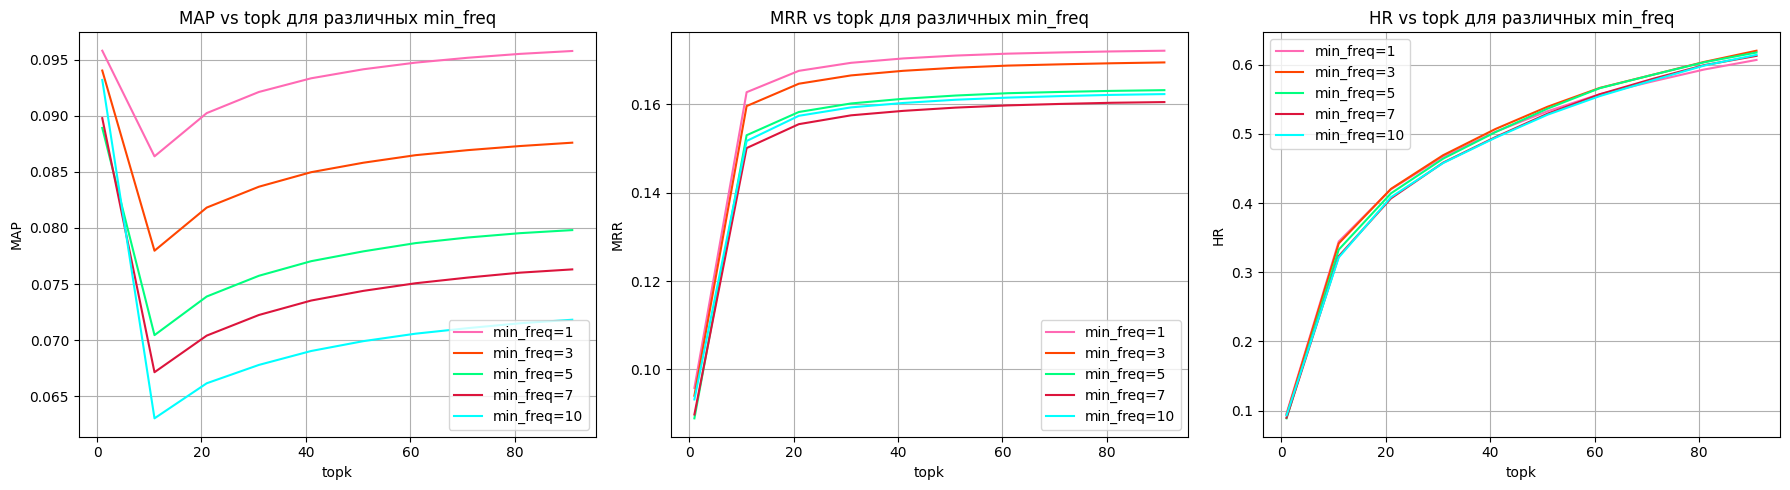

In [ ]:
# В данном примере мы будем фильтровать только тренировочные данные и оставлять в тестовой выборке только тех пользователей, которые присутствуют в отфильтрованном training.
min_freq_thresholds = [1, 3, 5, 7, 10]

# Словарь для хранения результатов: для каждого порога min_freq будем сохранять список значений метрик для каждого topk.
results = {}

for min_freq in min_freq_thresholds:
    print(f"Обрабатываем min_freq = {min_freq}\n\n")
    filtered_train_df = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=min_freq)

    # Оставляем только пользователей, присутствующих и в тестовой выборке
    valid_users = np.intersect1d(filtered_train_df.user_id.unique(), test_df.user_id.unique())
    filtered_train_df = filtered_train_df[filtered_train_df.user_id.isin(valid_users)]
    filtered_test_df = test_df[test_df.user_id.isin(valid_users)]

    # Группируем данные для формирования объединённого DataFrame:
    train_grouped = filtered_train_df.groupby('user_id')\
        .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\
        .reset_index().rename(columns={0: 'train_interactions'})
    test_grouped = filtered_test_df.groupby('user_id')\
        .apply(lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda z: z[1])])\
        .reset_index().rename(columns={0: 'test_interactions'})
    joined_filt = train_grouped.merge(test_grouped)

    # Перекодируем тренировочный DataFrame:
    filtered_train_encoded, user2id, item2id = df_encode(filtered_train_df)
    # Строим разреженную матрицу интеракций:
    matrix_filt = sps.coo_matrix(
        (np.ones(filtered_train_encoded.shape[0]),
         (filtered_train_encoded['user_id'], filtered_train_encoded['item_id'])),
        shape=(len(user2id), len(item2id))
    )
    w = fit_ease(matrix_filt, reg_weight=1000)
    id2item = {v: k for k, v in item2id.items()}

    topk_values = range(1, 101, 10)
    map_list = []
    mrr_list = []
    hr_list  = []

    # Для каждого значения topk вычисляем метрики по всем пользователям
    for k in topk_values:
        ap_scores = []
        rr_scores = []
        hr_scores = []
        for idx, row in joined_filt.iterrows():
            gt_items = [x[0] for x in row['test_interactions']]
            # Получаем рекомендации с помощью EASE для данного пользователя
            preds = get_preds(row['train_interactions'], item2id, id2item)
            preds = preds[:k]
            ap_scores.append(ap_metric(gt_items, preds, topn=k))
            rr_scores.append(rr_metric(gt_items, preds, topn=k))
            hr_scores.append(hr_metric(gt_items, preds, topn=k))
        map_list.append(np.mean(ap_scores))
        mrr_list.append(np.mean(rr_scores))
        hr_list.append(np.mean(hr_scores))

    results[min_freq] = {'topk': list(topk_values), 'map': map_list, 'mrr': mrr_list, 'hr': hr_list}

# Графики, где по оси x отложен topk, а для каждой метрики выведены кривые для разных значений min_freq.
colors = ['#FF69B4', '#FF4500', '#00FF7F', '#DC143C', '#00FFFF']
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
for i, min_freq in enumerate(min_freq_thresholds):
    plt.plot(results[min_freq]['topk'], results[min_freq]['map'], label=f"min_freq={min_freq}", color=colors[i])
plt.xlabel("topk")
plt.ylabel("MAP")
plt.title("MAP vs topk для различных min_freq")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
for i, min_freq in enumerate(min_freq_thresholds):
    plt.plot(results[min_freq]['topk'], results[min_freq]['mrr'], label=f"min_freq={min_freq}", color=colors[i])
plt.xlabel("topk")
plt.ylabel("MRR")
plt.title("MRR vs topk для различных min_freq")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
for i, min_freq in enumerate(min_freq_thresholds):
    plt.plot(results[min_freq]['topk'], results[min_freq]['hr'], label=f"min_freq={min_freq}", color=colors[i])
plt.xlabel("topk")
plt.ylabel("HR")
plt.title("HR vs topk для различных min_freq")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**

1. Чем больше min_freq, тем ниже MAP. Это ожидаемо, так как при фильтрации частотных айтемов теряются редкие, но релевантные рекомендации.
2. Разница между кривыми при разных min_freq становится заметной только при малых значениях top-K, а затем стабилизируется.
3. Более низкие min_freq дают чуть более высокие значения MRR.
4. Различия между min_freq незначительны, так как MRR зависит только от первого релевантного элемента, а его позиция не сильно меняется при росте min_freq.
5. HR постепенно растёт, но разница между min_freq почти не видна.
6. Чем выше top-K, тем больше вероятность, что релевантный элемент окажется в рекомендациях.

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.

In [ ]:
import random
selected_items = random.sample(list(item2id.keys()), 10)

print("Топ-5 рекомендаций по модели EASE для выбранных фильмов:\n")

for item in selected_items:
    # Получаем индекс в матрице весов
    item_idx = item2id[item]

    # Копируем строку весов и исключаем сам фильм
    similarity_scores = w[item_idx].copy()
    similarity_scores[item_idx] = -np.inf  # Исключаем сам фильм

    # Получаем топ-5 наиболее схожих фильмов
    recommended_idxs = np.argsort(similarity_scores)[-5:][::-1]

    # Декодируем индексы обратно в item_id
    recommended_items = [id2item[idx] for idx in recommended_idxs]

    # Название оригинального фильма
    original_title = items.loc[items.item_id == item, "title"].values[0]

    # Названия рекомендованных фильмов
    recommended_titles = []
    for rec_id in recommended_items:
        title = items.loc[items.item_id == rec_id, "title"].values
        recommended_titles.append(title[0] if len(title) > 0 else str(rec_id))

    # Выводим рекомендации
    print(f"Фильм: '{original_title}' (ID {item})")
    for rank, title in enumerate(recommended_titles, 1):
        print(f"  {rank}. {title}")
    print()

Топ-5 рекомендаций по модели EASE для выбранных фильмов:

Фильм: 'Стендап под прикрытием' (ID 7417)
  1. Прабабушка легкого поведения
  2. День города
  3. Афера
  4. Секреты семейной жизни
  5. #Только серьёзные отношения

Фильм: 'В ловушке' (ID 7230)
  1. Вирус страха
  2. В пасти океана
  3. Отец
  4. Он тебя не отпустит
  5. Модификаты

Фильм: 'Танец Дели' (ID 8168)
  1. Верю в любовь
  2. Шери
  3. Век Адалин
  4. Небеса подождут
  5. Маша

Фильм: 'Золотая молодёжь' (ID 3463)
  1. Белый снег
  2. Королева сердец
  3. За мечтой
  4. Сиськи
  5. Маленькое красное платье

Фильм: 'Карман России' (ID 4218)
  1. Рядовой Чээрин
  2. Мастер меча
  3. Лето - это море
  4. Радиовспышка
  5. Сахаров. Две жизни

Фильм: 'Психо' (ID 8469)
  1. Девятаев
  2. Окно во двор
  3. Хостел
  4. Птицы
  5. Марионетка

Фильм: 'За бортом' (ID 1598)
  1. За бортом
  2. Гнев человеческий
  3. Doom: Аннигиляция
  4. Один дома
  5. Ромовый дневник

Фильм: 'Русские школьницы' (ID 13468)
  1. Маленькие куколки


Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**

Довольно-таки хорошие рекомендации, например, для "Очень страшное кино 5", "Русские школьницы", "Золотая модольдежь", "Психо", "Стендап под прикрытием" и т.д, но для фильма "За бортом", как мне кажется, не очень хорошие рекомендации, так как Гнев человеческий и Doom: Аннигиляция явно не подходят. Возможно это из-за большого перекоса из-за популярности и проблемы с тегами, учитывая, что для фильма за бортом рекомендовали этот же фильм